In [1]:
import csv
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime 
import scipy as stats 
import statsmodels.api as sm 
from scipy import stats 
from statsmodels.tsa.arima_model import ARIMA 

F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
data = pd.read_excel('E:/postgraduate/案例选题数据及说明/美小麦连续1.xlsx')

In [19]:
data['时间'] = data['时间'].str.split(',').str[0]
data.index = data['时间']
data = data[['开盘','最高','最低','收盘','总手']]
data.head()

,开盘,最高,最低,收盘,总手
时间,,,,,
2021-01-12,636.25,670.00,634.00,664.75,76800
2021-01-13,665.00,680.75,656.25,659.25,76421
2021-01-14,660.00,673.25,653.00,670.50,57699
2021-01-15,671.00,693.00,664.50,674.75,75385
2021-01-19,683.75,691.25,668.75,673.25,61713


In [29]:
data1 = data.loc['2021-01-12':'2022-02-23']
data1.tail()

,开盘,最高,最低,收盘,总手
时间,,,,,
2022-02-16,779.75,786.75,773.25,779.00,30459
2022-02-17,780.00,799.25,775.50,796.75,39362
2022-02-18,797.50,812.25,790.00,793.75,37767
2022-02-22,815.00,846.25,803.00,839.75,44590
2022-02-23,841.00,880.00,834.00,874.50,26272


Text(0, 0.5, '收盘价')

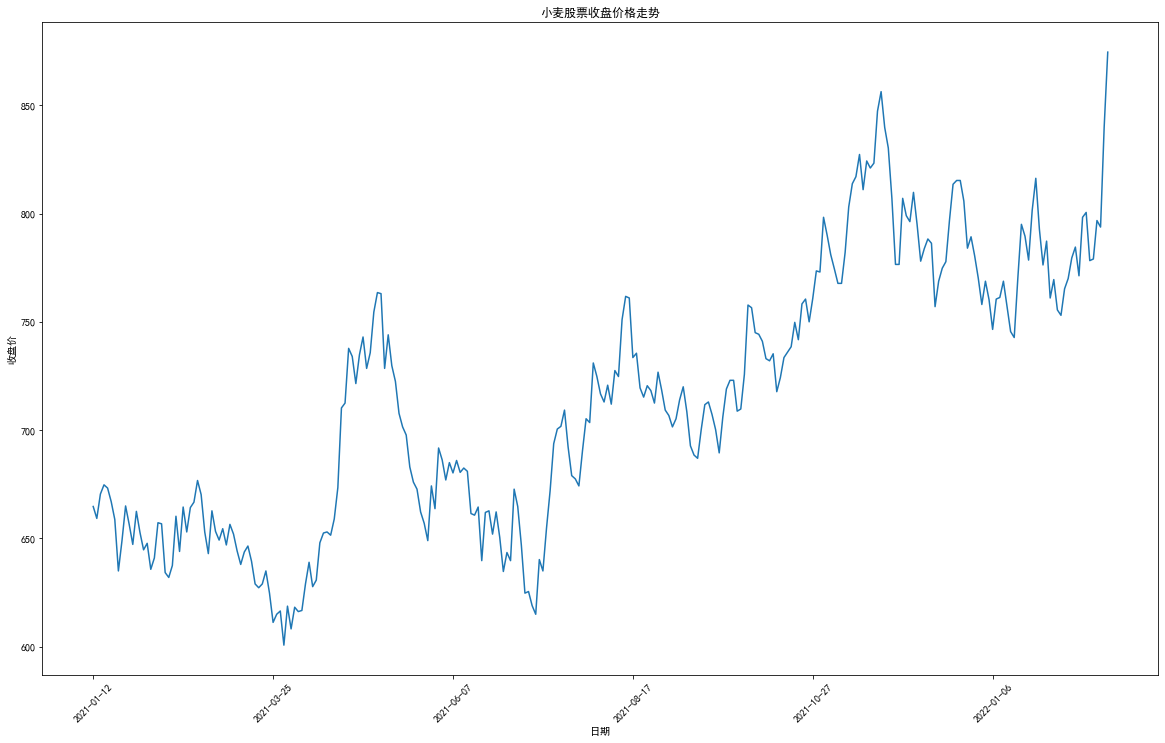

In [30]:
ts = data1['收盘']
plt.rcParams['font.sans-serif'] = ['simhei']  #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号 
ts.plot(figsize=(20,12))         
plt.title("小麦股票收盘价格走势")  #添加图标题 
plt.xticks(rotation=45)    #横坐标旋转45度
plt.xlabel('日期')   #添加图的标签（x轴，y轴）
plt.ylabel('收盘价')

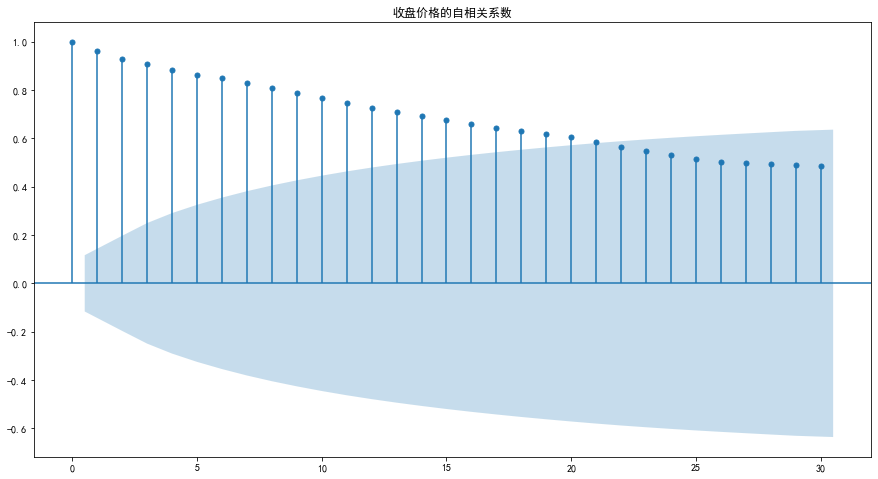

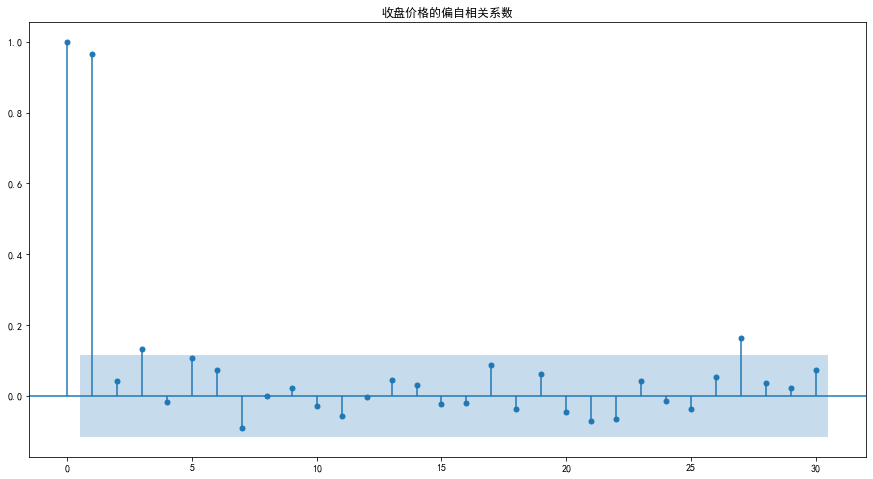

In [31]:
# 绘制自相关图 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf#导入自相关函数 
plt.rcParams['figure.figsize'] = (15,8)
plot_acf(ts,use_vlines=True,lags=30,title = '收盘价格的自相关系数')  #"lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图
plot_pacf(ts,use_vlines=True,lags=30,title = '收盘价格的偏自相关系数')
plt.show()  #展示原始数据"ts"的自相关图

In [36]:
#原始数据平稳性检测（单位根检验） 
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts,autolag = 'AIC')
print('原始序列的ADF检验结果为：',result) #展示单位根检验结果

原始序列的ADF检验结果为： (-0.9805599995698072, 0.7602884001259747, 0, 282, {'1%': -3.4537536300652, '5%': -2.8718443180148836, '10%': -2.572260641818822}, 2137.9340380562903)


ADF检验的结果p值为0.76>0.05，所以无法拒绝原假设，说明该股票的收盘价序列是非平稳的

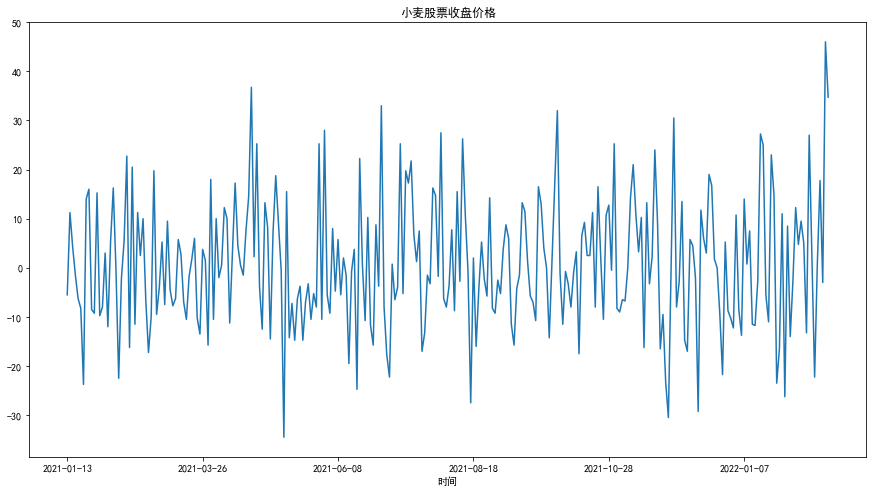

In [37]:
# 进行一阶差分 
D_ts = ts.diff().dropna()   #对"ts数列"进行差分 

# 绘制差分后时序图 
D_ts.plot()  #绘制出差分后的时序图 
plt.title("小麦股票收盘价格")  #添加图标题 
plt.show()   #展示差分后的时序图

#iff1 = data['收盘'].diff(1).dropna()
#adftest_diff1 = adfuller(diff1,autolag = 'AIC')
#print(('diff1 result is \n{}'.format(adftest_diff1)))

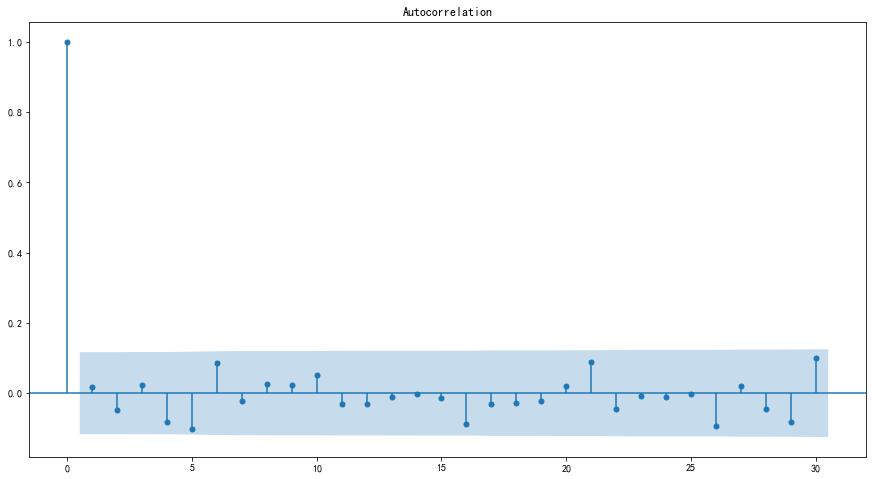

In [38]:
from statsmodels.graphics.tsaplots import plot_acf #导入自相关函数 # 绘制差分后自相关图与偏自相关图 
plot_acf(D_ts,use_vlines=True,lags=30)  #"lags"自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图 
plt.show() #展示差分后数据"D_ts"的自相关图

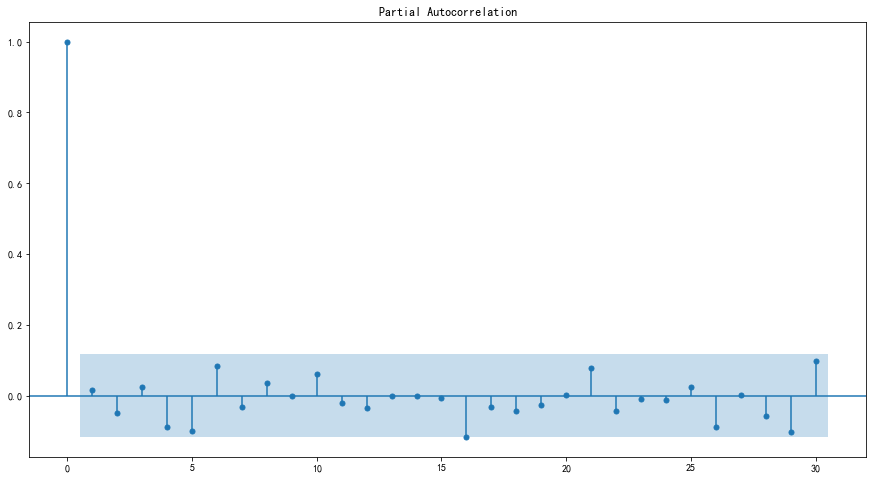

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf  #导入偏自相关函数 
plot_pacf(D_ts,use_vlines=True,lags=30) #"lags"偏自相关函数的滞后取值范围，此处之后30阶，绘制出原始数据"ts"的自相关图 
plt.show()  #展示差分后数据"D_ts"的偏自相关图

In [40]:
result1 = adfuller(D_ts,autolag = 'AIC')
print('差分后序列的ADF检验结果为：',result1)

差分后序列的ADF检验结果为： (-16.23667806253753, 3.7636812410087356e-29, 0, 281, {'1%': -3.4538376962008495, '5%': -2.8718811911083093, '10%': -2.5722803076202174}, 2131.9388234516628)


由检验结果显示得出，Test Statistic的值是-16.23667806253753小于Critical Value给出的1%，5%，10%显著性水平下的临界值，同时p-value=3.7636812410087356e-29<0.05,因此拒绝原假设，说明该开盘价序列经一阶差分后是平稳的。

In [41]:
# 对差分后数据进行白噪声检验 
from statsmodels.tsa import stattools #对差分后达到平稳的数据进行白噪声检验 
LjungBox=stattools.q_stat(stattools.acf(D_ts)[1:12],len(D_ts)) #展示白噪声检验结果，返回统计量和p值 
LjungBox[1][-1]

F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


0.5564534550377744

由运行出来的结果，我们可以得知，p-value=0.5564534550377744>0.05,因此无法拒绝原假设,也就是说此时差分后开盘价序列是平稳白噪声序列。

In [42]:
from statsmodels.tsa.arima_model import ARIMA   
model=ARIMA(ts,order=(1,1,0)) 
result=model.fit(disp=-1) 
result.summary()


F:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D.收盘   No. Observations:                  282
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1129.507
Method:                       css-mle   S.D. of innovations             13.282
Date:                Wed, 09 Mar 2022   AIC                           2265.014
Time:                        11:24:42   BIC                           2275.940
Sample:                             1   HQIC                          2269.396
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7455      0.804      0.927      0.354      -0.831       2.322
ar.L1.D.收盘     0.0169      0.060      0.280      0.779      -0.101       0.135
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           59.3157           +0.0000j           59.3157            0.0000
-----------------------------------------------------------------------------
"""

In [43]:
result.conf_int()#模型诊断

,0,1
const,-0.831229,2.322218
ar.L1.D.收盘,-0.101056,0.134773


上述模型诊断结果中，通过z检验，我们发现P值均大于0.05，即无法拒绝原假设，说明模型诊断不通过，且系数的置信区间包含零，因此不能说在5%的置信水平下，所有系数都是显著的，从而推翻AR(1)模型。

In [50]:
model2=ARIMA(ts,order=(0,1,0)) 
result2=model2.fit(disp=-1) 
result2.summary()

F:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D.收盘   No. Observations:                  282
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1129.546
Method:                           css   S.D. of innovations             13.284
Date:                Wed, 09 Mar 2022   AIC                           2263.093
Time:                        11:38:44   BIC                           2270.377
Sample:                             1   HQIC                          2266.014
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7438      0.791      0.940      0.347      -0.807       2.294
==============================================================================
"""

In [51]:
result2.conf_int()#模型诊断

,0,1
const,-0.806613,2.294202


In [46]:
sm.tsa.arma_order_select_ic(D_ts,max_ar=6,max_ma=4,ic='aic')['aic_min_order']

F:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
F:\anaconda\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pa

F:\anaconda\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
F:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
 

F:\anaconda\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
F:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
 

(0, 0)

In [47]:
from statsmodels.tsa.arima_model import ARIMA 
model=ARIMA(ts,order=(0,1,0)) 
result=model.fit(disp=-1) 
result.summary()

F:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D.收盘   No. Observations:                  282
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1129.546
Method:                           css   S.D. of innovations             13.284
Date:                Wed, 09 Mar 2022   AIC                           2263.093
Time:                        11:34:46   BIC                           2270.377
Sample:                             1   HQIC                          2266.014
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7438      0.791      0.940      0.347      -0.807       2.294
==============================================================================
"""

In [48]:
result.conf_int()  #模型诊断

,0,1
const,-0.806613,2.294202
